- This study focus in analysing the relation of inflation in Brazil, with *SOME* of the main factors, for the lack of reliable datasets to support all the causations, accordingly with economics theory, and to keep the attention in the main indexes.
- Factors used: 
Interest Rate (IR); 
Money Supply (MS); 
Minimum Wages (MW); 
General Government Debt (GD); 
partial inflation rates that forms the final index (Inflation aggregates). All Datasets was downloaded from the Central Bank of Brazil.   


## Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# Importing the Datasets: Interest Rate(ir); Money Supply(ms); Minimum Wages(mw); General Government Debt(gd);
# partial inflation rates that forms the final index (inflation)
ir = pd.read_csv('IR.csv', sep=';', encoding='latin-1')
ms = pd.read_csv('MS.csv', sep=';', encoding='latin-1', thousands='.')
mw = pd.read_csv('MW.csv', sep=';', encoding='latin-1', thousands='.')
gd = pd.read_csv('GD.csv', sep=';', encoding='latin-1', thousands='.')
inflation = pd.read_csv('INFLATION.csv', sep=';', encoding='latin-1')

pd.set_option('float_format', '{:.2f}'.format)
pd.set_option('display.max_rows', 20)

In [3]:
# Renaming the Columns
ir.rename(columns = {'Data':'date', "4390 - Taxa de juros - Selic acumulada no mês - % a.m.":'int_rate'}, inplace=True)

ms.rename(columns = {'Data':'date', "1786 - BM - Papel moeda emitido (saldo em final de período) - u.m.c. (mil)":
                     'money_supply'}, 
                      inplace=True)

mw.rename(columns = {'Data':'date', "1619 - Salário mínimo - u.m.c.":'min_wages'}, 
                      inplace=True)

gd.rename(columns = {'Data':'date', "4501 - Divida líquida do governo geral - Saldos em R$ milhões - R$ (milhões)":
                     'gov_debt'}, 
                     inplace=True)

inflation.rename(columns = {'Data':'date', 
                  
                 '433 - Índice nacional de preços ao consumidor-amplo (IPCA) - Var. % mensal':'inflation',
                   
                 '1635 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Alimentação e bebidas - Var. % mensal':
                 'food',
                   
                 '1636 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Habitação - Var. % mensal':'housing',
                   
                 '1637 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Artigos de residência - Var. % mensal':
                 'house_items',
                   
                 '1638 - Índice nacional de preços ao consumidor-Amplo (IPCA)- Vestuário - Var. % mensal':'clothing',
                   
                 '1639 - Índice de nacional de preços ao consumidor-Amplo (IPCA) - Transportes - Var. % mensal':
                 'transport',
                  
                 '1640 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Comunicação - Var. % mensal':
                 'communication',
                   
                 '1641 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Saúde e cuidados pessoais - Var. % mensal':
                 'health',
                   
                 '1642 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Despesas pessoais - Var. % mensal':
                 'personal',
                   
                 '1643 - Índice nacional de preços ao consumidor-Amplo (IPCA) - Educação - Var. % mensal': 'education'},
                 inplace=True)

In [4]:
# Merging all datasets into one, called 'merge3'
merged = inflation.merge(ir, on='date')
merged1 = merged.merge(ms, on='date')
merged2 = merged1.merge(mw, on='date') 
merged3 = merged2.merge(gd, on='date')

In [5]:
# Changing the dates to datetime format
merged3['date'] = pd.to_datetime(merged3['date'])

# Cropping the period from January/2000 to October/2021
mask = (merged3['date'] >= '2000-01-01') & (merged3['date'] <= '2021-10-1')
merged3 = merged3.loc[mask]
merged3.reset_index(drop=True, inplace=True)

# Save adjusted dataset 
merged3.to_csv('inflation_factors.csv', index=False)
inflation_factors = pd.read_csv('inflation_factors.csv', thousands='.', decimal=',')

inflation_factors

,date,inflation,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,money_supply,min_wages,gov_debt
0,2000-01-01,0.62,0.84,0.19,0.43,0.21,0.39,1.82,0.59,0.12,3.05,1.46,24199689,136.00,492136.23
1,2000-02-01,0.13,-0.25,0.01,0.29,-0.67,0.40,0.04,0.22,0.36,1.32,1.45,23068674,136.00,494285.94
2,2000-03-01,0.22,-0.46,0.17,0.28,-1.44,1.68,0.07,0.27,-0.07,-0.26,1.45,22732484,136.00,493089.13
3,2000-04-01,0.42,-0.36,0.00,0.19,0.72,0.51,-0.29,0.07,3.55,0.01,1.30,23279829,151.00,500897.64
4,2000-05-01,0.01,-0.67,0.45,0.25,0.35,0.13,0.18,0.03,0.13,0.07,1.49,22470333,151.00,505608.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2021-06-01,0.53,0.43,1.10,1.09,1.21,0.41,-0.12,0.51,0.29,0.05,0.31,340095553,1100.00,5133428.61
258,2021-07-01,0.96,0.60,3.10,0.78,0.53,1.52,0.12,-0.65,0.45,0.18,0.36,343812587,1100.00,5191114.72
259,2021-08-01,0.87,1.39,0.68,0.99,1.02,1.46,0.23,-0.04,0.64,0.28,0.43,341302698,1100.00,5212554.57
260,2021-09-01,1.16,1.02,2.56,0.90,0.31,1.82,0.07,0.39,0.56,-0.01,0.44,336844324,1100.00,5262849.94


 ## EDA


In [6]:
inflation_factors.info(verbose=True, memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 262 entries, 0 to 261
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           262 non-null    object 
 1   inflation      262 non-null    float64
 2   food           262 non-null    float64
 3   housing        262 non-null    float64
 4   house_items    262 non-null    float64
 5   clothing       262 non-null    float64
 6   transport      262 non-null    float64
 7   communication  262 non-null    float64
 8   health         262 non-null    float64
 9   personal       262 non-null    float64
 10  education      262 non-null    float64
 11  int_rate       262 non-null    float64
 12  money_supply   262 non-null    int64  
 13  min_wages      262 non-null    float64
 14  gov_debt       262 non-null    float64
dtypes: float64(13), int64(1), object(1)
memory usage: 45.9 KB


In [7]:
inflation_factors.describe()

,inflation,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,money_supply,min_wages,gov_debt
count,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00,262.00
mean,0.51,0.61,0.56,0.30,0.43,0.47,0.32,0.50,0.56,0.55,0.96,141142973.18,570.75,1913657.79
std,0.39,0.83,0.70,0.54,0.57,0.88,1.11,0.41,0.45,1.33,0.40,91219940.13,304.50,1305104.17
min,-0.38,-1.07,-2.38,-1.37,-1.44,-2.66,-1.65,-0.71,-0.25,-3.47,0.13,22470333.00,136.00,492136.23
25%,0.26,0.07,0.23,-0.03,0.08,-0.03,-0.01,0.32,0.29,0.04,0.68,55632399.25,300.00,970264.49
50%,0.45,0.58,0.48,0.29,0.47,0.34,0.07,0.43,0.50,0.13,0.94,133103061.00,510.00,1481819.22
75%,0.69,1.03,0.77,0.56,0.85,0.78,0.28,0.64,0.71,0.35,1.23,205271965.00,880.00,2484994.07
max,3.02,5.85,5.29,2.88,1.91,4.68,9.31,2.74,3.55,6.70,2.08,370441036.00,1100.00,5289723.28


All data was downloaded from the Central Bank of Brazil, so no relevant changes were made in the EDA process.

## Data Splits

In [8]:
# Label split
label = inflation_factors[['inflation']]
label

,inflation
0,0.62
1,0.13
2,0.22
3,0.42
4,0.01
...,...
257,0.53
258,0.96
259,0.87
260,1.16


In [9]:
# Features split
features_to_scale = inflation_factors.iloc[:, 2:]
features_to_scale

,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,money_supply,min_wages,gov_debt
0,0.84,0.19,0.43,0.21,0.39,1.82,0.59,0.12,3.05,1.46,24199689,136.00,492136.23
1,-0.25,0.01,0.29,-0.67,0.40,0.04,0.22,0.36,1.32,1.45,23068674,136.00,494285.94
2,-0.46,0.17,0.28,-1.44,1.68,0.07,0.27,-0.07,-0.26,1.45,22732484,136.00,493089.13
3,-0.36,0.00,0.19,0.72,0.51,-0.29,0.07,3.55,0.01,1.30,23279829,151.00,500897.64
4,-0.67,0.45,0.25,0.35,0.13,0.18,0.03,0.13,0.07,1.49,22470333,151.00,505608.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,0.43,1.10,1.09,1.21,0.41,-0.12,0.51,0.29,0.05,0.31,340095553,1100.00,5133428.61
258,0.60,3.10,0.78,0.53,1.52,0.12,-0.65,0.45,0.18,0.36,343812587,1100.00,5191114.72
259,1.39,0.68,0.99,1.02,1.46,0.23,-0.04,0.64,0.28,0.43,341302698,1100.00,5212554.57
260,1.02,2.56,0.90,0.31,1.82,0.07,0.39,0.56,-0.01,0.44,336844324,1100.00,5262849.94


In [10]:
features_to_scale.dtypes

food             float64
housing          float64
house_items      float64
clothing         float64
transport        float64
communication    float64
health           float64
personal         float64
education        float64
int_rate         float64
money_supply       int64
min_wages        float64
gov_debt         float64
dtype: object

## Scaling

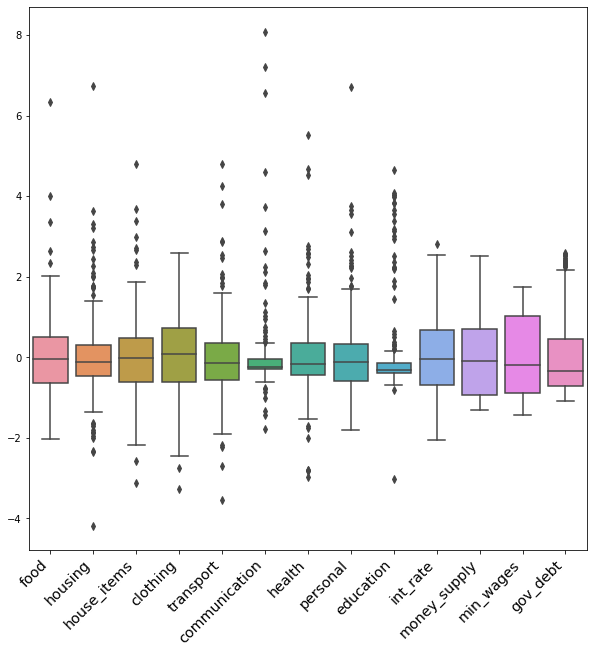

In [11]:
# Scaling Features
scaling = StandardScaler()
features_scaled = scaling.fit_transform(features_to_scale)


# ndarray to DataFrame
features_names = (['food', 'housing', 'house_items', 'clothing', 'transport',
                   'communication', 'health', 'personal', 'education', 'int_rate',
                   'money_supply', 'min_wages', 'gov_debt'])

features = pd.DataFrame(features_scaled, columns=features_names, dtype=(float))


# Distributions of Features
plt.figure(figsize=(10,10))
plt.xticks(rotation=45, horizontalalignment='right', fontsize='x-large')
sns.boxplot(data=features)

None # dont show the label objects

The outliers wasn't deleted, because they aren't errors, but justify oscillations considered necessary to the moment.

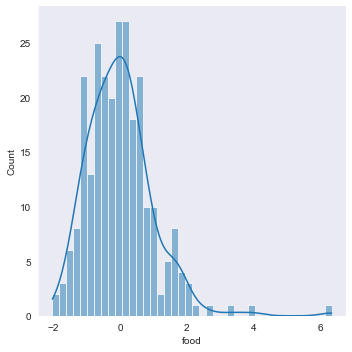

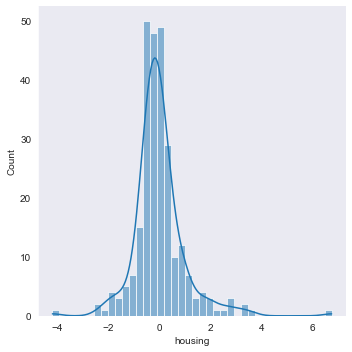

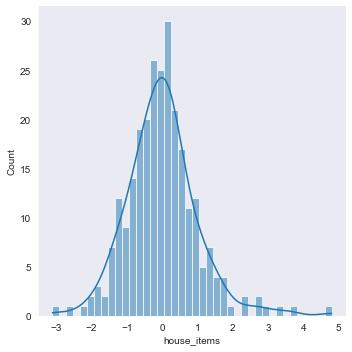

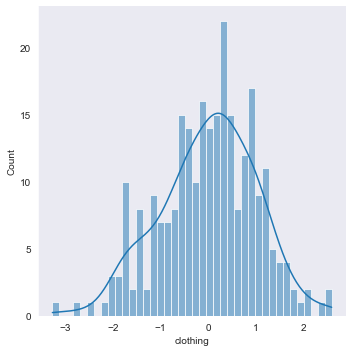

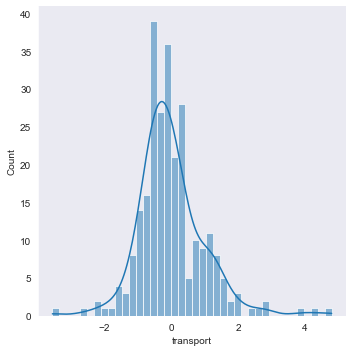

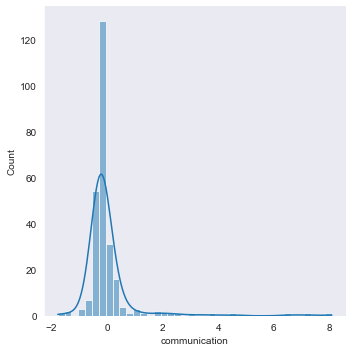

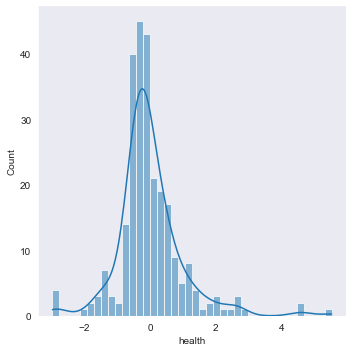

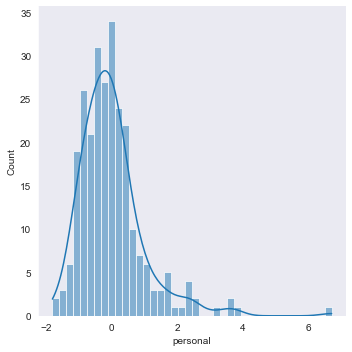

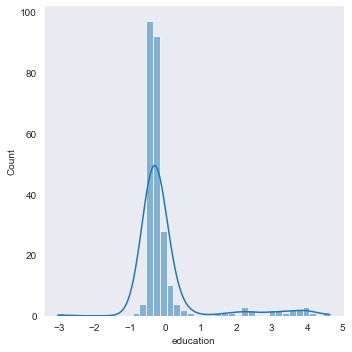

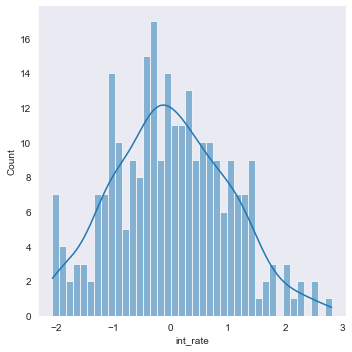

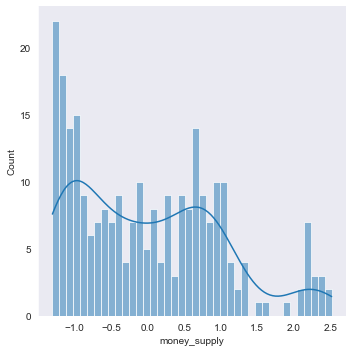

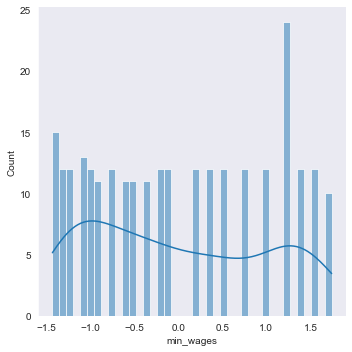

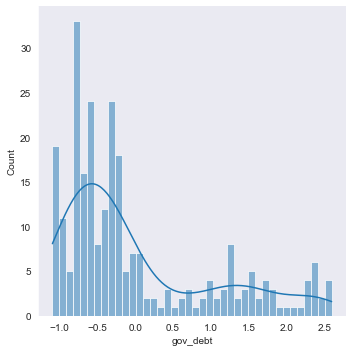

In [12]:
# Histogram of each Feature
for columns in features.columns:
    sns.set_style('dark')
    sns.displot(data=features[columns], kde=True, bins=40, height=5, aspect=1)
    plt.show(columns)

<AxesSubplot:>

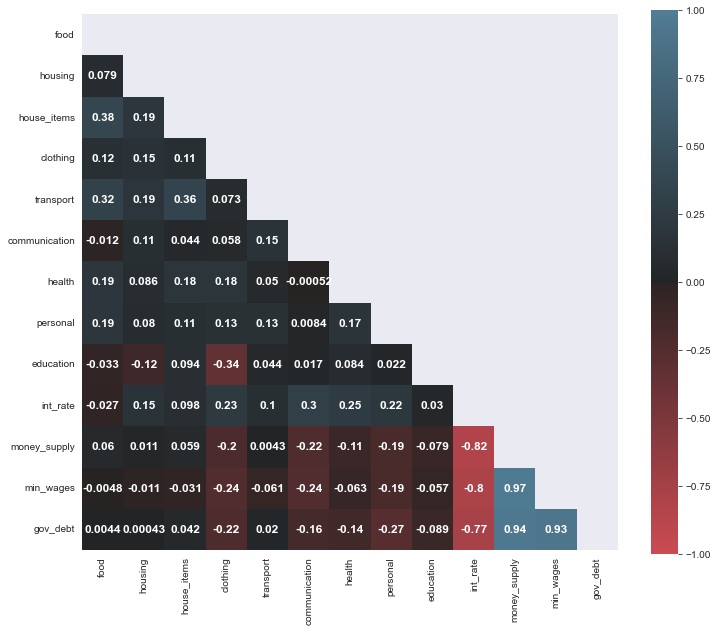

In [13]:
# Correlations map
mask = np.triu(np.ones_like(features.corr()))
cmap = sns.diverging_palette(10, 230, as_cmap=True, center="dark", s=60)

plt.figure(figsize=(12,10))

sns.heatmap(features.corr(), cmap=cmap, square=True, center=0, vmin=-1, vmax=1, 
            annot=True, mask=mask, annot_kws={'fontsize':12, 'fontweight':'bold'})

Clearly the features money_supply and gov_debt has redundant information, which are contained in the min_wages features

In [14]:
# Dropping features: money_supply, gov_debt
features.drop(['money_supply', 'gov_debt', ], inplace=True, axis=1)
features

,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,min_wages
0,0.28,-0.52,0.24,-0.39,-0.09,1.35,0.23,-0.98,1.88,1.26,-1.43
1,-1.04,-0.78,-0.02,-1.92,-0.08,-0.26,-0.68,-0.44,0.58,1.24,-1.43
2,-1.29,-0.55,-0.04,-3.27,1.38,-0.23,-0.56,-1.40,-0.61,1.24,-1.43
3,-1.17,-0.79,-0.21,0.50,0.05,-0.55,-1.05,6.71,-0.41,0.86,-1.38
4,-1.55,-0.15,-0.10,-0.14,-0.38,-0.13,-1.15,-0.96,-0.36,1.34,-1.38
...,...,...,...,...,...,...,...,...,...,...,...
257,-0.22,0.77,1.47,1.36,-0.06,-0.40,0.03,-0.60,-0.38,-1.62,1.74
258,-0.01,3.62,0.89,0.17,1.20,-0.18,-2.83,-0.24,-0.28,-1.49,1.74
259,0.95,0.17,1.28,1.03,1.13,-0.08,-1.32,0.19,-0.20,-1.32,1.74
260,0.50,2.85,1.12,-0.21,1.54,-0.23,-0.26,0.01,-0.42,-1.29,1.74


In [15]:
# Train-Test Split definition
features_train, features_test, label_train, label_test = train_test_split(features, label, train_size= 0.7,
                                                                          random_state=1)

In [16]:
print(features_test.mean().mean())
print(features_test.std().mean())

0.05589366754594193
1.0383202952528041


## Modeling

In [17]:
# Adding noise to the test set (features_test), with a mean of 0.1, and standard
# deviation of 0.5, considering the values are already Standarized
noise = np.random.normal(0.1, 0.5, (79, 11))

features_test = features_test + noise
features_test

,food,housing,house_items,clothing,transport,communication,health,personal,education,int_rate,min_wages
258,-0.02,3.14,1.55,-0.23,0.49,-0.30,-2.37,-0.60,0.70,-0.56,2.09
12,-0.41,-0.73,1.32,-0.79,0.64,0.85,-0.76,-0.09,0.93,0.85,-0.48
118,-0.22,-0.16,0.43,0.69,0.10,-0.55,-0.60,0.17,-0.53,-0.18,-0.44
67,-1.60,-0.47,-0.14,-0.65,0.88,-0.31,0.98,0.44,-0.58,1.57,-1.45
236,-0.86,-0.32,-2.89,-0.58,0.42,0.45,0.97,-0.65,-0.60,-1.61,2.59
...,...,...,...,...,...,...,...,...,...,...,...
253,-0.07,-0.18,0.94,-0.19,2.81,-0.26,0.43,-1.01,1.61,-2.09,2.08
69,-0.55,1.27,-0.62,1.03,1.63,-0.27,-0.14,0.08,0.28,1.16,-1.03
180,1.06,2.93,-1.09,-1.83,1.76,0.13,-0.01,2.64,-0.01,0.18,1.38
114,-1.16,1.54,0.61,-1.56,-0.44,0.57,-0.42,-1.33,0.33,-0.60,-1.19


In [18]:
# Support Vector Regression got the best results
# Others results are below, in the next section
svr = SVR(kernel='linear')
svr.fit(features_train, label_train.to_numpy().ravel())
label_pred_svr = svr.predict(features_test)

In [19]:
# Exporting the model with pickle
pickle.dump(svr, open("model_ipca.pkl", "wb"))

In [20]:
# Prediction Results
print('Coefficients:', svr.coef_)
print('Intercept:', svr.intercept_)
print('Mean squared error: {:.4f}'.format(mean_squared_error(label_test, label_pred_svr)))
print('Coefficient of determination: {:.4f}'.format(r2_score(label_test, label_pred_svr)))

Coefficients: [[ 0.16585076  0.08975286  0.03559792  0.01783885  0.16276733  0.03593281
   0.05512257  0.04992161  0.05441595  0.01215981 -0.00143492]]
Intercept: [0.52925671]
Mean squared error: 0.0264
Coefficient of determination: 0.8789


In [21]:
# Contribution of each feature  

coefficients = {'Factors':['food', 'housing', 'house_items', 'clothing', 
                           'transport', 'communication', 'health', 'personal', 
                           'education', 'int_rate', 'min_wages'],
                 'Coeffs':[0.16585076, 0.08975286, 0.03559792, 0.01783885,  
                           0.16276733, 0.03593281, 0.05512257, 0.04992161,  
                           0.05441595, 0.01215981, -0.00143492]}
      
contribution = pd.DataFrame(coefficients)
pd.set_option('float_format', '{:.4f}'.format)         
        
contribution = contribution.sort_values(by='Coeffs', ascending=False).style.hide_index()
contribution

Factors,Coeffs
food,0.165851
transport,0.162767
housing,0.089753
health,0.055123
education,0.054416
personal,0.049922
communication,0.035933
house_items,0.035598
clothing,0.017839
int_rate,0.012160


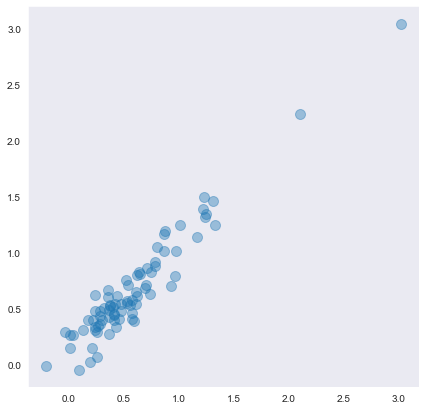

In [22]:
# Plot comparing the distributions of Label values with the Predicted values 
plt.figure(figsize=(7,7))
plt.scatter(x=label_test, y=label_pred_svr, alpha=.4, s=100)

None

## Models Tests



In [23]:
gpr = GaussianProcessRegressor()
gpr.fit(features_train, label_train)
label_pred_gpr = gpr.predict(features_test)

print('Mean squared error (MSE): {:.4f}'.format(mean_squared_error(label_test, label_pred_gpr)))
print('Coefficient of determination (R^2): {:.4f}'.format(r2_score(label_test, label_pred_gpr)))

Mean squared error (MSE): 0.4660
Coefficient of determination (R^2): -1.1336


In [24]:
pr = PolynomialFeatures(degree=3)
features_poly = pr.fit_transform(features_train)
pr.fit(features_train, label_train)    

lr = linear_model.LinearRegression() 
lr.fit(features_poly, label_train)
label_pred_poly = lr.predict(pr.fit_transform(features_test)) 

print('Mean squared error (MSE): {:.4f}'.format(mean_squared_error(label_test, label_pred_poly)))
print('Coefficient of determination (R^2): {:.4f}'.format(r2_score(label_test, label_pred_poly)))

Mean squared error (MSE): 0.8665
Coefficient of determination (R^2): -2.9677


In [25]:
rf = RandomForestRegressor(random_state=0)
rf.fit(features_train, label_train.to_numpy().ravel())
label_pred_rf = rf.predict(features_test)

print('Mean squared error (MSE): {:.4f}'.format(mean_squared_error(label_test, label_pred_rf)))
print('Coefficient of determination (R^2): {:.4f}'.format(r2_score(label_test, label_pred_rf)))

Mean squared error (MSE): 0.0496
Coefficient of determination (R^2): 0.7727


In [26]:
lr = linear_model.LinearRegression()    
lr.fit(features_train, label_train)    
label_pred_lr = lr.predict(features_test)  

print('Mean squared error (MSE): {:.4f}'.format(mean_squared_error(label_test, label_pred_lr)))
print('Coefficient of determination (R^2): {:.4f}'.format(r2_score(label_test, label_pred_lr)))

Mean squared error (MSE): 0.0310
Coefficient of determination (R^2): 0.8580


# Conclusion


In the analysed period, January/2000 to October/2021, the most basic necessities, food, transport and housing, were the main prices affected by the inflation. 
In the Economics theory, the main factor to inflation are the increase in money supply, in which are represented here by goverment debt, money supply itself and minimal wages (that contain the information overall in this case, correlation). The main actions central banks can take to control the inflation, are adjusting the Interest Rates; mandatory reservers by the banks; and purchasing government bonds from banks on the secondary market.

The solutions presented above, influence the yields in the capital markets, and even if inflation rises, we can link the investiments to it, and keep the value of money, that means, no significant difference at all for who does this. Some call inflation a hidden tax, and it's weight is carry by those with less purchasing power, who are affected more and don't have the means to invest, so the prices in food and transport are very important for daily activities of the overall population, who in the period, ended up paying the most for it. 

As Alan Greenspan, who was the president of the FED from August/1987 to January/2006, said in interview to national television, when questioned about what should be the proper relationship between the FED and the US goverment: "...the FED is a independent agency(...), there's no other agency of goverment which can overrule actions that we take, so long that is in place, and there's no evidence that the administration, or the congress, or anybody else is requesting that we do things, other than what we think is the appropriate thing,  than what the relationships are, don't frankly matter". But he was just talking about the Central Bank of the US.